<a href="https://colab.research.google.com/github/AlexJurcich/Machine-learning/blob/main/Predicting_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Heart Disease**

My goal is to accurately predict the likelihood of a new patient having heart disease in the future.

Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

Import data

In [ ]:
df = pd.read_csv("heart_disease_prediction.csv")

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Our dataset includes 918 total rows with 12 columns. There is no missing data. 5 categorical variables and 7 numerical variables. However **FastingBS** and **HeartDisease** are binary thus should be considered as categorical.

In [ ]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


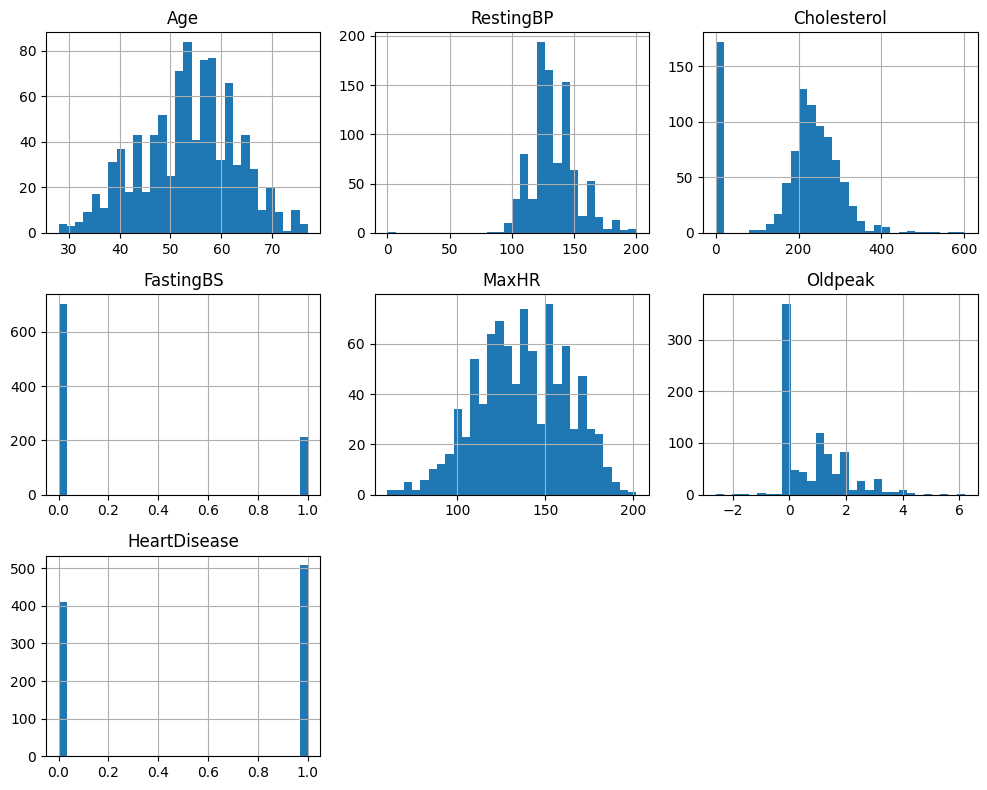

In [14]:
# Distribution plots for numeric data
df.hist(figsize=(10, 8), bins=30)
plt.tight_layout()
plt.show()



*   The avergae age of patients is around **53** years.
*   We see that Cholesterol is missing values
*   Age and MaxHR are noramlly distributed
*   We also see that RestingBP  and Choleterol have min values of **0** which is impossible.








In [ ]:
# Distribution plots for categorical data

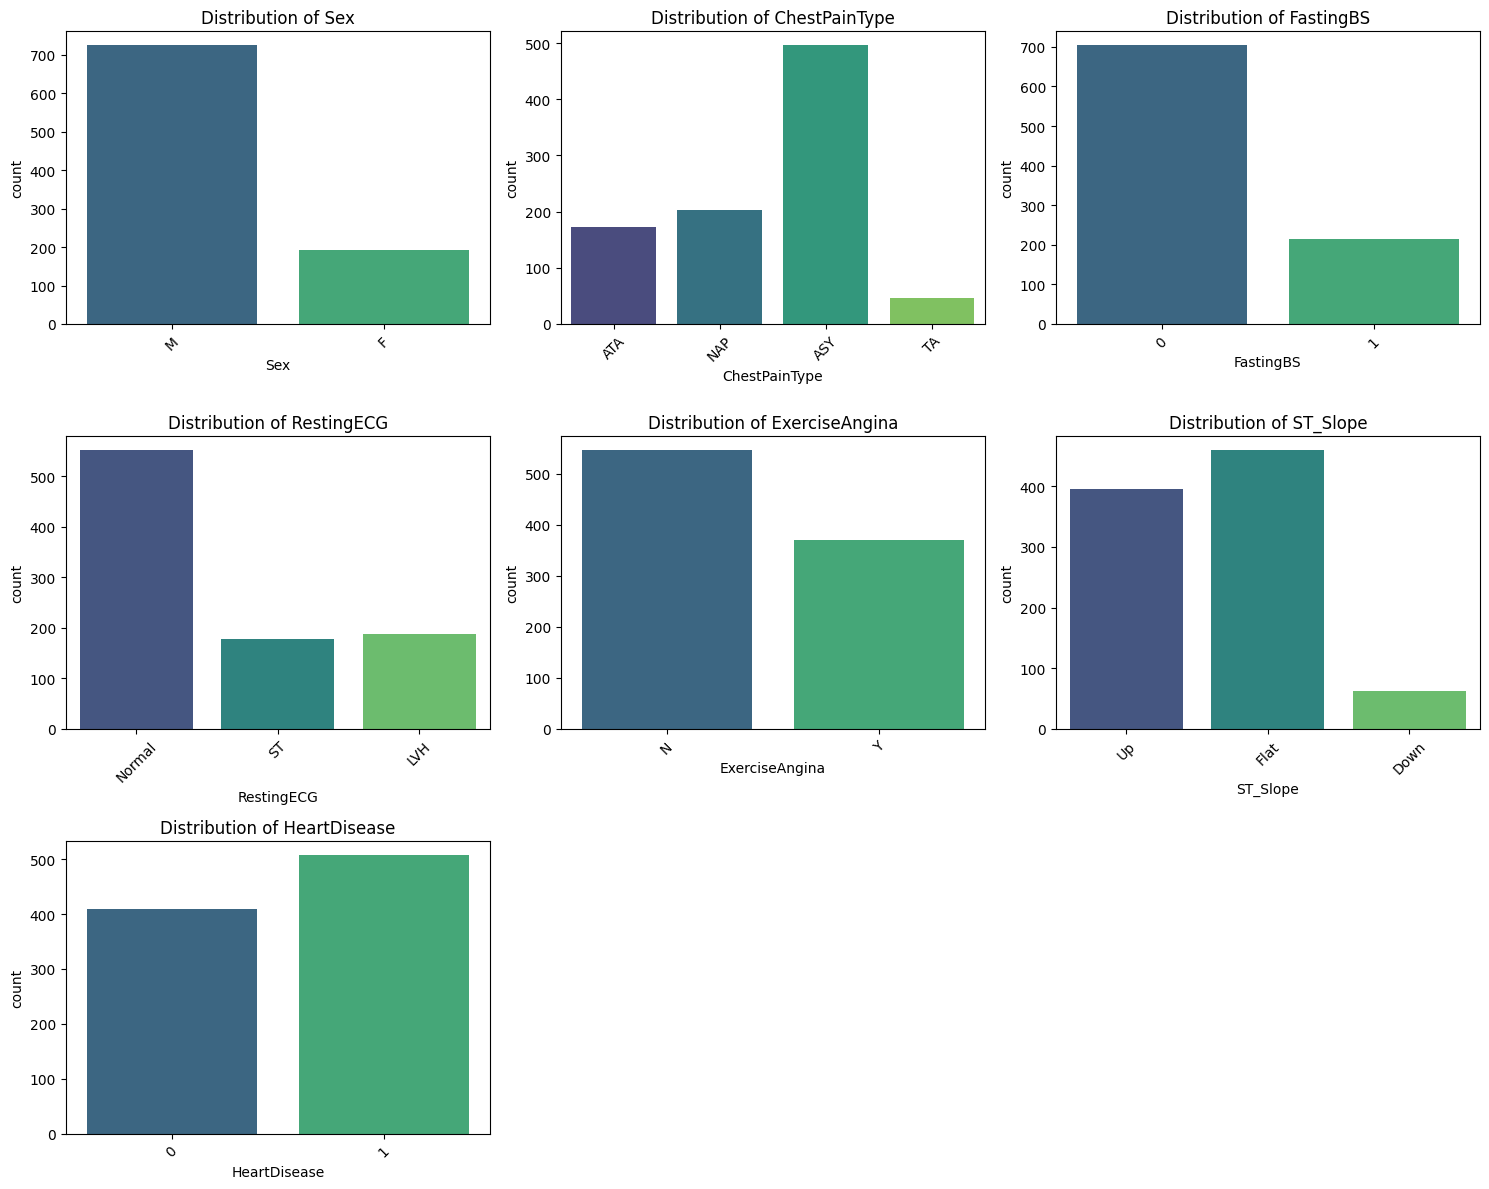

In [12]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_cols, 1):
  plt.subplot(3, 3, i)
  sns.countplot(data=df, x=col, hue=col, legend=False, palette="viridis")
  plt.title(f'Distribution of {col}')
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


*   The dataset is highly skwed towards males. There are **725** males and **193** females which could introduce bias on our model.
*   The most common chest pain type is **ASY** having **496** instances.



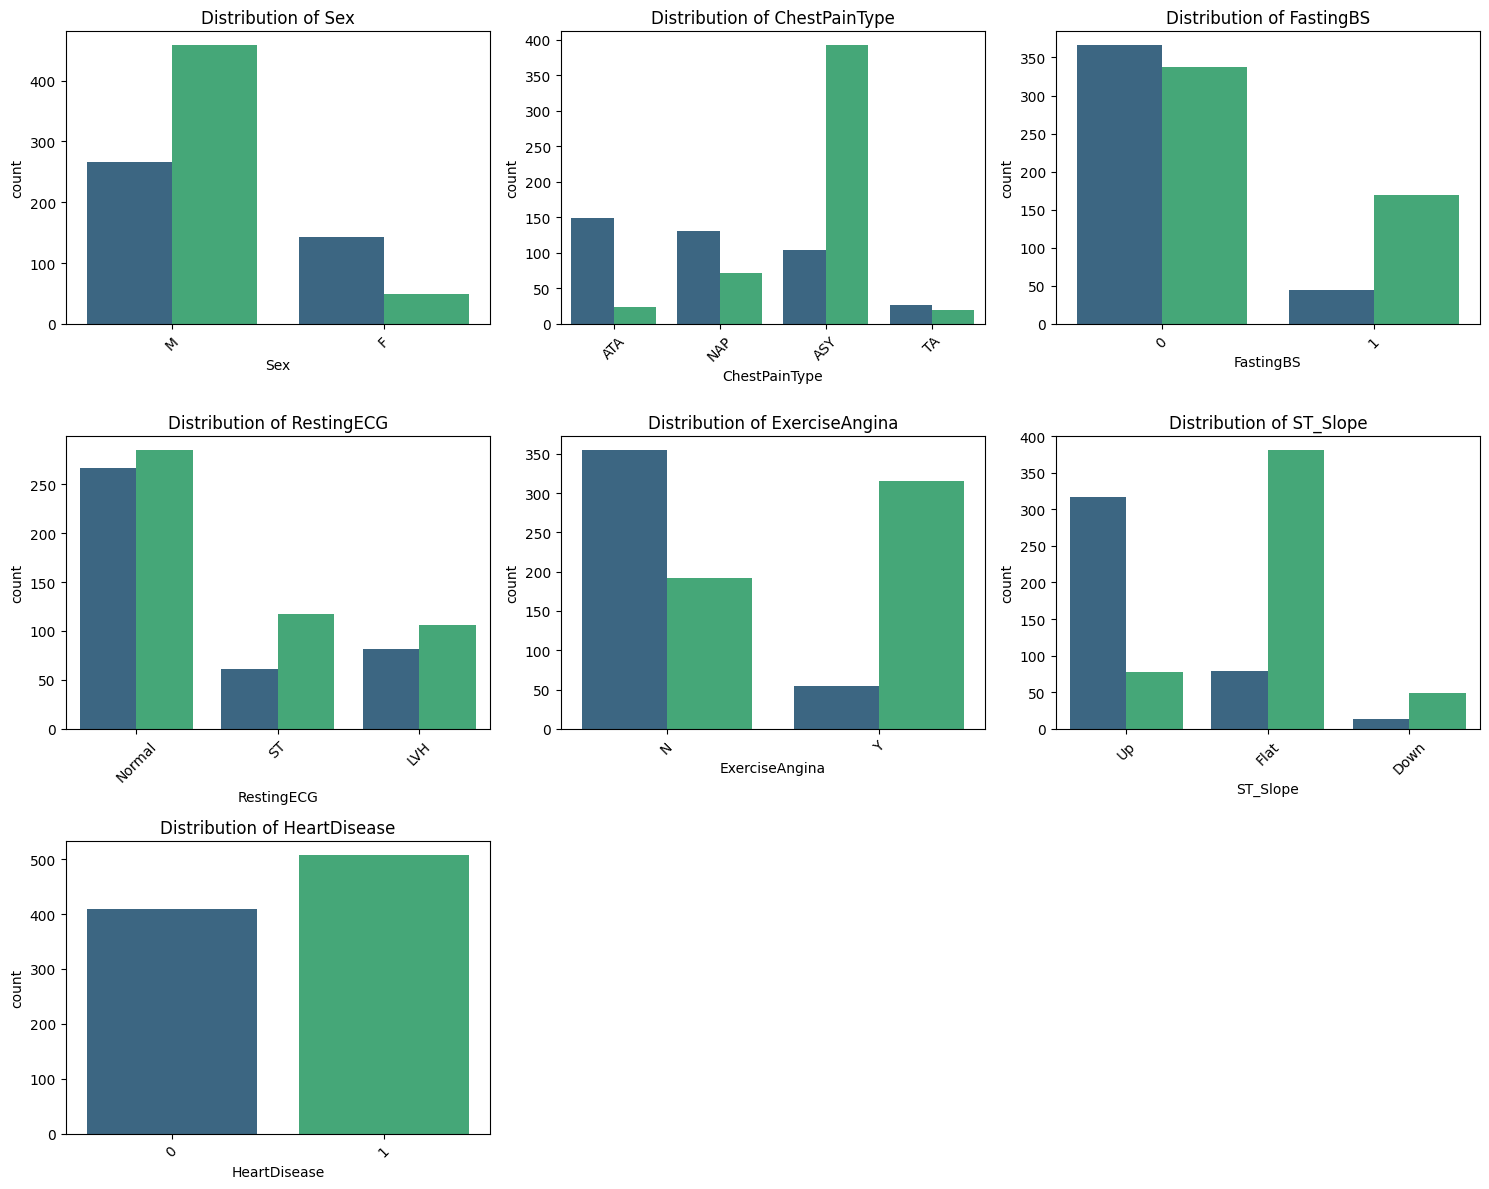

In [15]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_cols, 1):
  plt.subplot(3, 3, i)
  sns.countplot(data=df, x=col, hue=df['HeartDisease'], legend=False, palette="viridis")
  plt.title(f'Distribution of {col}')
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



*   Only **50** females have been diagnosed with heart disease
*  A significant number of patients, **392**, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
*   Out of all patients who had an exercise-induced angina, **316** were diagnosed with a heart disease.






# Data Cleaning

We will start by addresing the columns with 0 values that are impossible considering the context.

In [20]:
# RestingBP
missing_RestingBP = df[df['RestingBP'] == 0].shape[0]
print(f"Number of missing values in RestingBP: {missing_RestingBP}")

# Cholesterol
missing_Cholesterol = df[df['Cholesterol'] == 0].shape[0]
print(f"Number of missing values in Cholesterol: {missing_Cholesterol}")

Number of missing values in RestingBP: 1
Number of missing values in Cholesterol: 172


I will remove the 1 missing instance from RestingBP. For the 172 missing values in cholesterol I will replace them with the median of the individuals who were diagnosed with heart disease and the same for those not diagnosed.

In [25]:
df_clean = df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value =
                                         cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value =
                                      cholesterol_with_heartdisease.median())

In [28]:
# Recheck the stats
df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


We see that the min values are better and the median and means are simular.

# Feature Selection

Hot encode categorical variables

In [29]:
df_clean = pd.get_dummies(df_clean, drop_first=True)

df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


Compute Correlation Matrix

In [30]:
corr_matrix = df_clean.corr(numeric_only=True)

target_corr = corr_matrix["HeartDisease"].sort_values(ascending=False)
print(target_corr)

HeartDisease         1.000000
ST_Slope_Flat        0.553700
ExerciseAngina_Y     0.495490
Oldpeak              0.403638
Sex_M                0.305118
Age                  0.282012
FastingBS            0.267994
RestingBP            0.117990
RestingECG_ST        0.103067
Cholesterol          0.024914
ChestPainType_TA    -0.054591
RestingECG_Normal   -0.092452
ChestPainType_NAP   -0.215311
MaxHR               -0.401410
ChestPainType_ATA   -0.401680
ST_Slope_Up         -0.621843
Name: HeartDisease, dtype: float64


Given the correlations above we can narrow our selection down to:

*   Oldpeak
*   Sex_M
*   ExerciseAngina_Y
*   ST_Slope_Flat
*   ST_Slope_Up



## Building Classifer with One Feature

Split data

In [36]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15,
                                                  random_state = 42)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

Evaluate the performance for each of the selected features

In [41]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 70.29%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 68.12%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 61.59%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 75.36%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 78.26%


ST_Slope_Up is our best performing model with an accuracy of **78.26%** followed by ST_Slope_Flat.

# Building a Classifier with Multiple Features

Scale features

In [42]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

Evaluate the performance

In [43]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 78.26


The model performed exactly the same as ST_Slope_Up

# Hyperparameter Optimization

Split and Scale the data

In [44]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state = 42)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

Use Grid Search to find the best parameters

In [46]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

knn_grid.best_score_*100, knn_grid.best_params_

(84.84615384615385, {'metric': 'minkowski', 'n_neighbors': 14})

Our best model has an accuracy of **~84.85%** with **14 n_neighbors** and **minkowski** as the distance metric.

This is a better result than we acheived before.

# Model Evaluation on Test Set

Normalize the test set

In [47]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 80.43


Slight fall off in the models accuarcy of **~4%**

Compare distributin of patients to see cause

In [48]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     609
False    170
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     115
False     23
Name: count, dtype: int64


We can see that the above datasets have a significantly higher number of male patients than female ones. We briefly mentioned previously that this could present a bias because of this imbalance in our dataset and we can see it potentially impacts our model. If the test dataset doesn't have that many female patients and the model was trained on a dataset with more male patients, then it is understandable it has better accuracy on the test set. Of course, there could be other factors contributing to this discrepancy.

# Summary

Our final model was trained using the following features:

*   Oldpeak
*   Sex_M
*   ExerciseAngina_Y
*   ST_Slope_Flat
*   ST_Slope_Up

and had a test accuarcy of **80.43%**. Given that our data was highly skewed towards men I don't believe my model is very good.

In order to truely predict Heart Disease we would need a data set with less bias towards sex.